In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 스마트팜 배출량에 대한 예측
- smart_farm_final.csv

## Feature Engineering
- Q. 시간 데이터를 효과적으로 모델에 포함시킬 수 있는 방법이 없나?
- A. hour,minute을 합해서 float으로 변환하기, sin_time, cos_time을 추가하기
- Q. 온도와 습도가 결국 스마트팜에 있어서 중요한 요인이기에 파생변수를 추가하기
- A. 온도와 습도를 통해서 만들 수 있는 이슬점 데이터를 추가하기
- Q. 일출시간, 일몰시간을 기반으로 zenith(태양의 고도) 계산하기
- A. 태양의 고도가 곧, 일사량과 태양 복사 에너지에 주된, 요인이기에 핵심적인 요인으로 이용될 수도 있음

In [2]:
#data = pd.read_csv("smart_farm_final.csv")
org_data = pd.read_csv("smart_farm_final.csv")
org_data.shape

(148168, 57)

- 이슬점 데이터 생성하기

In [3]:
c = 243.12
b = 17.62
gamma = (b * (org_data['내부 온도']) / (c + (org_data['내부 온도']))) + np.log(org_data['내부 습도'] / 100)
dp = ( c * gamma) / (b - gamma)
org_data['이슬점'] = dp

- merge hour and minute feature into 1

In [4]:
org_data["hour_float"] = org_data.시 + org_data.분/60

- add cyclical encoded time feature
- continueous time feature

In [5]:
org_data['cos_time'] = np.cos(2*np.pi*(org_data.hour_float/24))
org_data['sin_time'] = np.sin(2*np.pi*(org_data.hour_float/24))

일출 일몰 시간에 따른 년간, 일별 계절성(seasonality)를 고려한 일별 2차 함수 근사를 통해 zenith angle 산출
- zenith angle (태양의 고도)

In [6]:
import numpy as np
import os

import random
import math
from scipy.optimize import curve_fit

In [7]:
def obj_curve(x, a, b, c):
    return a*(x-b)**2+c

일출, 일몰시간 데이터 다루기
- float 형태로 변환해주기

In [8]:
import gc

gc.collect()

75

#### 시,분 string 을 float으로 변경하는 함수 : hour_str_to_float

In [9]:
def hour_str_to_float(x):
    hour = int(str(x)[:-2])
    minute = int(str(x)[-2:])
    
    return hour + minute/60

In [10]:
sunrise_data = org_data[["시간","일출시간","일몰시간","hour_float"]].copy()

sunrise_data["일출시간_float"] = sunrise_data["일출시간"].apply(lambda x : hour_str_to_float(x))
sunrise_data["일몰시간_float"] = sunrise_data["일몰시간"].apply(lambda x : hour_str_to_float(x))

In [11]:
sunrise_data.head(3)

,시간,일출시간,일몰시간,hour_float,일출시간_float,일몰시간_float
0,2021-11-26 00:00:00,713,1717,0.000000,7.216667,17.283333
1,2021-11-26 00:01:00,713,1717,0.016667,7.216667,17.283333
2,2021-11-26 00:02:00,713,1717,0.033333,7.216667,17.283333


In [12]:
zenith_lst = np.load("zenith.npy")

In [13]:
sunrise_data["zenith"] = zenith_lst

- altutude of sun is added

In [14]:
sunrise_data['altitude'] = 90-sunrise_data.zenith

In [15]:
sunrise_data.head(3)

,시간,일출시간,일몰시간,hour_float,일출시간_float,일몰시간_float,zenith,altitude
0,2021-11-26 00:00:00,713,1717,0.000000,7.216667,17.283333,231.228926,-141.228926
1,2021-11-26 00:01:00,713,1717,0.016667,7.216667,17.283333,230.739259,-140.739259
2,2021-11-26 00:02:00,713,1717,0.033333,7.216667,17.283333,230.250259,-140.250259


In [16]:
data = pd.merge(org_data.drop(["일출시간","일몰시간"],axis=1),
                sunrise_data[["일출시간_float","일몰시간_float","zenith","altitude","시간"]],
                on="시간", how = "inner")

시간 데이터 처리하기
- 연도 : numerical
- 월 : non numerical
- 일 : non numerical
- 시 : non numerical
- 분 : non numerical

In [17]:
data = data.drop(["년월일","일","분"],axis=1)

#### 일출,일몰 3시간, 1시간반 데이터 처리하기

In [18]:
data["일출3시간후_float"] = data["일출3시간후"].apply(lambda x : hour_str_to_float(x))
data["일몰3시간후_float"] = data["일몰3시간후"].apply(lambda x : hour_str_to_float(x))
data["일출1시간후_float"] = data["일출1시간후"].apply(lambda x : hour_str_to_float(x))
data["일몰1시간반전_float"] = data["일몰1시간반전"].apply(lambda x : hour_str_to_float(x))

In [19]:
data = data.drop(["일출3시간후_float","일몰3시간후_float","일출1시간후_float","일몰1시간반전_float"],axis=1)

#### 팬코일 B동 데이터
- 0과 1이 아닌, 0.5 발견
- 반올림 처리하기

In [20]:
data["팬코일 B동"] = data["팬코일 B동"].apply(lambda x : 1 if x == 0.5 else x )

In [21]:
data.drop(["차열스크린_광도조절","차광스크린_광도조절"],axis=1,inplace=True)

발전량 시간대별 평균, 표준편차 파생변수 추가하기

In [22]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

In [23]:
test["열공급량(kWh)"]

129448   NaN
129449   NaN
129450   NaN
129451   NaN
129452   NaN
          ..
148163   NaN
148164   NaN
148165   NaN
148166   NaN
148167   NaN
Name: 열공급량(kWh), Length: 18720, dtype: float64

In [24]:
## 시간대별 열공급량 평균 넣어주기
power_hour_mean = pd.pivot_table(train, values = '열공급량(kWh)', index = ['시'], aggfunc = np.mean).reset_index()
power_hour_mean.columns = ["시","시간대별_평균열공급량"]

power_hour_std = pd.pivot_table(train, values = '열공급량(kWh)', index = ['시'], aggfunc = np.std).reset_index()
power_hour_std.columns = ["시","시간대별_열공급량표준편차"]

In [25]:
# 데이터 연결하가

data = pd.merge(data,power_hour_mean,on="시",how="left")
data = pd.merge(data,power_hour_std,on="시",how="left")

In [26]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

#### 광도조절 데이터 제거하기
- 데이터가 다 똑같음

In [27]:
train["열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

문자열 칼럼 추출

In [28]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [29]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ["월","일","시",'배기팬','유동팬','팬코일 B동',"차광스크린_개방",
                                                "열공급량(kWh)","환기온도(천창 제어온도)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동', "차광스크린_개방","환기온도(천창 제어온도)"]

object_no_binary = [x for x in object_lst_real if x not in ["배기팬","유동팬","팬코일 B동","차광스크린_개방","환기온도(천창 제어온도)"]]

#### MeanEncoding을 하기 위한 EDA 작업하기
- object_lst_real : categorial data
- num_lst_real : numeric data

In [30]:
object_lst_real

['시간',
 '차광스크린_개방조절',
 '차열스크린_온도조절',
 '차열스크린_개방조절',
 '시간범주',
 '일몰전후',
 '일출일몰',
 '오존등급',
 '아황산가스등급',
 '이산화질소등급',
 'PM10등급',
 'PM25등급',
 '배기팬',
 '유동팬',
 '팬코일 B동',
 '차광스크린_개방',
 '환기온도(천창 제어온도)']

#### Object 데이터
- 차광스크린 광도조절
- 차열스크린 광도조절
- 데이터 제거하기

## MeanEncoding 대신 One Hot 이나 Ordinary로 만들기
- 해당 버전은 Mean Encoding 적용하지 않기

In [31]:
data = pd.concat([train,test],axis=0)

In [32]:
data.loc[:129447,"열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

Object로 확인된 모든 데이터

In [33]:
data[object_no_binary]

,시간,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,시간범주,일몰전후,일출일몰,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급
0,2021-11-26 00:00:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,좋음,좋음,좋음,보통,보통
1,2021-11-26 00:01:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,좋음,좋음,좋음,보통,보통
2,2021-11-26 00:02:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,좋음,좋음,좋음,보통,보통
3,2021-11-26 00:03:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,좋음,좋음,좋음,보통,보통
4,2021-11-26 00:04:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,좋음,좋음,좋음,보통,보통
...,...,...,...,...,...,...,...,...,...,...,...,...
148163,2022-03-20 23:55:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,보통,좋음,좋음,좋음,좋음
148164,2022-03-20 23:56:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,보통,좋음,좋음,좋음,좋음
148165,2022-03-20 23:57:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,보통,좋음,좋음,좋음,좋음
148166,2022-03-20 23:58:00,0%~30%개방,23도미만,0%~30%개방,야간,일몰1시간반_후,일몰,보통,좋음,좋음,좋음,좋음


### Ordinary 한 Categorical Data Encoding
- Ordinary : 차광스크린_개방조절, 차열스크린_온도조절, 차열스크린_개방조절, 오존등급, 아황산가스등급
- 나머지 Object 데이터인 시간범주, 일몰전후, 일출일몰은 원핫인코딩

In [34]:
data_encode = data.copy()

for col in ["차열스크린_개방조절"]:
    
    map_df = pd.DataFrame(index = ['0%~30%개방', '30%~70%개방', '70%~100%개방','100%개방'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
for col in ["차광스크린_개방조절"]:
    
    map_df = pd.DataFrame(index = ['0%~30%개방', '30%~80%개방', '80%~100%개방','100%개방'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
    
for col in ["차열스크린_온도조절"]:
    
    map_df = pd.DataFrame(index = ['23도미만','23도~25도', '25도~26도', '26도이상'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
for col in ["오존등급", "아황산가스등급","이산화질소등급","PM10등급","PM25등급"]:
    
    # mapping 하기 위한 DataFrame
    map_df = pd.DataFrame(index = sorted(data_encode[col].value_counts().index.values),
             data = [i for i in range(len(data_encode[col].value_counts()))],
             columns = [col])[col]

    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)

In [35]:
data = data_encode.copy()

In [36]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

In [37]:
train["열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

##### binary categorial 은 원핫인코딩(get_dummies)하지 않기
- 희소행렬이 만들어지는 것을 방지하기 위함
- 환기온도도 categorical처럼 보이지만 크기 자체에 의미가 있어서 numerical로

## 변수 선택 이전 스케일링, 로그변환, 이상치 처리

#### 이상치 대체하기
- 스크린 계열 데이터 0 ~ 100이니까 처리하지 않기

In [38]:
def replace_outlier_zscore(df,columns,n):
    data = df.copy()
    mean = np.mean(data[columns])
    std = np.std(data[columns])
    score_top = int(n)*std + mean
    score_bot = -1*n*std + mean
    
    def cond1(x):
        if x > score_top:
            return score_top
        if x < score_bot:
            return score_bot
        else:
            return x
    data[columns] = data[columns].apply(cond1)
    
    return data[columns]

#### 일단 column별로 skew 값 먼저 확인하기
- 강수량을 제외한 천창, 아황산가스_1시간 데이터만 log 변환해주기

In [39]:
# 왜도 3인 설명변수 log1p 변환
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    if abs(data[val].skew()) > 2:
        print("log1p 변환이전 : ",abs(data[val].skew()))
        print(val)


log1p 변환이전 :  4.579098139125924
천창
log1p 변환이전 :  7.384725752483332
누적강수량
log1p 변환이전 :  3.13108520363669
아황산가스_1시간


log 변환해주기

In [40]:
for val in ["천창","아황산가스_1시간"]:
    data[val] = np.log1p(data[val])

이상치 대체하는 함수
- 강수량는 제외하고 진행하기

for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = data[col]

for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    data[col+"_scale"] = replace_outlier_zscore(data,col+"_scale",3)

len(['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도'])

이상치 개수 확인

In [108]:
for col in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도',
            '난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    
    if (data[col] == data[col+"_scale"]).sum() == 148168:
        pass
    else:
        print(col)
        print("이상치 비율 : ",(148168 - (data[col] == data[col+"_scale"]).sum()) / 148168 * 100)
        print(" ---------------------------------------------- ")
        
    data.drop([col+"_scale"],axis=1,inplace=True)

일사량(W/㎡)
이상치 비율 :  0.35500242967442364
 ---------------------------------------------- 
외기온(℃)
이상치 비율 :  0.22541979374763782
 ---------------------------------------------- 
풍속(m/s)
이상치 비율 :  1.6596026132498245
 ---------------------------------------------- 
내부 온도
이상치 비율 :  0.06816586577398628
 ---------------------------------------------- 
내부 습도
이상치 비율 :  0.8773824307542789
 ---------------------------------------------- 
누적강수량
이상치 비율 :  1.9565628205820422
 ---------------------------------------------- 
현지기압
이상치 비율 :  0.6195669780249446
 ---------------------------------------------- 
해면기압
이상치 비율 :  0.6087684250310459
 ---------------------------------------------- 
PM10_1시간
이상치 비율 :  1.5705145510501592
 ---------------------------------------------- 
PM25_1시간
이상치 비율 :  1.4071864370174396
 ---------------------------------------------- 
오존_1시간
이상치 비율 :  0.20247286863560285
 ---------------------------------------------- 
이산화질소_1시간
이상치 비율 :  0.3624264348577291
 ---------------------

#### 1. 숫자형 데이터 스케일링 진행
- 컬럼별로 스케일링 진행
- 스크린 계열 데이터 스케일링 진행하기

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [42]:
data.head()

,시간,년도,월,시,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급,이슬점,hour_float,cos_time,sin_time,일출시간_float,일몰시간_float,zenith,altitude,시간대별_평균열공급량,시간대별_열공급량표준편차
0,2021-11-26 00:00:00,2021,11,0,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,0,0,0.0,1,0.0,28,18.0,0.9,0.0,1018.2,1021.9,29180.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.889913,0.000000,1.000000,0.000000,7.216667,17.283333,231.228926,-141.228926,0.473398,0.248416
1,2021-11-26 00:01:00,2021,11,0,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,0,0,0.0,1,0.0,28,18.0,0.9,0.0,1018.2,1021.9,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,11.037352,0.016667,0.999990,0.004363,7.216667,17.283333,230.739259,-140.739259,0.473398,0.248416
2,2021-11-26 00:02:00,2021,11,0,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,0,0,0.0,1,1.0,28,18.0,0.9,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,11.080268,0.033333,0.999962,0.008727,7.216667,17.283333,230.250259,-140.250259,0.473398,0.248416
3,2021-11-26 00:03:00,2021,11,0,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,0,0,0.0,1,1.0,28,18.0,0.8,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.776831,0.050000,0.999914,0.013090,7.216667,17.283333,229.761926,-139.761926,0.473398,0.248416
4,2021-11-26 00:04:00,2021,11,0,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,0,0,0.0,1,1.0,28,18.0,1.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.869295,0.066667,0.999848,0.017452,7.216667,17.283333,229.274259,-139.274259,0.473398,0.248416


MeanEncoding으로 모든 데이터가 numeric으로 변했으니 min,max?

In [43]:
for val in [x for x in data.columns if x not in ["열공급량(kWh)","시간","시간범주","일출일몰","일몰전후"]]:

    minmax = MinMaxScaler()
    
    data_scaled = minmax.fit_transform(data[val].values.reshape(-1,1))
    data[val] = data_scaled

In [44]:
data.head(3)

,시간,년도,월,시,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급,이슬점,hour_float,cos_time,sin_time,일출시간_float,일몰시간_float,zenith,altitude,시간대별_평균열공급량,시간대별_열공급량표준편차
0,2021-11-26 00:00:00,0.0,0.909091,0.0,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5,0.9,0.0,0.506494,0.506452,0.757607,0.264957,0.283784,0.02381,0.320513,0.142857,0.040477,0.0,0.0,0.0,0.0,0.771429,0.771429,0.016129,0.012195,0.219231,야간,일몰1시간반_후,일몰,0.254545,1.0,1.0,1.0,0.5,0.5,0.216039,0.000000,1.000000,0.500000,0.630769,0.02381,0.935993,0.064007,0.914205,0.332737
1,2021-11-26 00:01:00,0.0,0.909091,0.0,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5,0.9,0.0,0.506494,0.506452,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.040477,0.0,0.0,0.0,0.0,0.771429,0.771429,0.016129,0.012195,0.219231,야간,일몰1시간반_후,일몰,0.254545,1.0,1.0,1.0,0.5,0.5,0.221648,0.000695,0.999995,0.502182,0.630769,0.02381,0.933628,0.066372,0.914205,0.332737
2,2021-11-26 00:02:00,0.0,0.909091,0.0,0.0,0.492063,0.643678,0.054545,0.281690,0.338983,0.536278,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,0.5,0.9,0.0,0.503247,0.503226,0.000000,0.264957,0.283784,0.02381,0.320513,0.142857,0.040477,0.0,0.0,0.0,0.0,0.771429,0.771429,0.016129,0.012195,0.219231,야간,일몰1시간반_후,일몰,0.254545,1.0,1.0,1.0,0.5,0.5,0.223281,0.001390,0.999981,0.504363,0.630769,0.02381,0.931266,0.068734,0.914205,0.332737


------------------------------------------------------------------------------------------------------------------------------------

"배기팬","유동팬","팬코일 B동","환기온도(천창 제어온도)" 카테고리열 데이터로 스케일링 필요없음
- 환기온도는 numerical로 보면 필요한 것 같기도...

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

X 데이터 처리하기
- dummy 처리
- 왜도 처리

In [45]:
data_scaled = data.copy()

In [46]:
data_scaled.shape

(148168, 60)

In [47]:
# 년도 데이터를 numerical로 처리하기
Y = data_scaled["열공급량(kWh)"]

X_dummy = data_scaled.drop("열공급량(kWh)",axis=1)
X_dummy = X_dummy.drop(["시간"],axis=1)
X_dummy = pd.get_dummies(X_dummy,columns = ["일출일몰","일몰전후","시간범주"])

Y값 맨끝으로 위치시키기

#### 등급 데이터 다 빼보기

In [71]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

In [72]:
X_dummy.columns

Index(['년도', '월', '시', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)', '풍속(m/s)', '풍향(º)',
       '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)', '에너지스크린(수평)', '에너지스크린(수직)',
       '배기팬', '천창', '유동팬', '팬코일 B동', '환기온도(천창 제어온도)', '난방온도(설정온도)', '누적강수량',
       '현지기압', '해면기압', '일조', 'PM10_1시간', 'PM25_1시간', '오존_1시간', '이산화질소_1시간',
       '일산화탄소_1시간', '아황산가스_1시간', '차광스크린_개방', '차광스크린_개방조절', '차열스크린_온도조절',
       '차열스크린_개방조절', '일출3시간후', '일출1시간후', '일몰3시간후', '일몰1시간반전', '하루길이', '지면온도',
       '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급', '이슬점', 'hour_float',
       'cos_time', 'sin_time', '일출시간_float', '일몰시간_float', 'zenith',
       'altitude', '시간대별_평균열공급량', '시간대별_열공급량표준편차', '일출일몰_일몰', '일출일몰_일출',
       '일몰전후_일몰1시간반_전', '일몰전후_일몰1시간반_후', '시간범주_그외', '시간범주_야간', '시간범주_주간'],
      dtype='object')

#### 범주 관련 변수들 다 제거해보기

In [73]:
data_scaled_final = data_scaled_final.drop(['오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급',
                                           "해면기압","일출일몰_일출","일몰전후_일몰1시간반_전","일출일몰_일몰",
                                           "일몰전후_일몰1시간반_후","시간범주_그외","시간범주_야간",
                                           "시간범주_주간","일출3시간후","일출1시간후","일몰3시간후","일몰1시간반전","시",
                                           "해면기압","일조","altitude"],axis=1)

In [74]:
train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

### VIF 수치확인해보기

In [75]:
train_data.head(3)

,년도,월,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),...,이슬점,hour_float,cos_time,sin_time,일출시간_float,일몰시간_float,zenith,시간대별_평균열공급량,시간대별_열공급량표준편차,열공급량(kWh)
0,0.0,0.909091,0.0,0.495238,0.643678,0.000000,0.901408,0.359322,0.485804,0.0,...,0.216039,0.000000,1.000000,0.500000,0.630769,0.02381,0.935993,0.914205,0.332737,0.9
1,0.0,0.909091,0.0,0.495238,0.643678,0.024242,0.954930,0.352542,0.507886,0.0,...,0.221648,0.000695,0.999995,0.502182,0.630769,0.02381,0.933628,0.914205,0.332737,0.9
2,0.0,0.909091,0.0,0.492063,0.643678,0.054545,0.281690,0.338983,0.536278,0.0,...,0.223281,0.001390,0.999981,0.504363,0.630769,0.02381,0.931266,0.914205,0.332737,0.9


In [76]:
X_train = train_data.iloc[:129448,:].drop("열공급량(kWh)",axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor
def feature_engineering_XbyVIF(X_train):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i)
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    return vif

vif = feature_engineering_XbyVIF(X_train)
vif['VIF_Factor'] = vif['VIF_Factor'].apply(lambda x : round(x,2))
print(vif)

    VIF_Factor        Feature
0      1157.88             년도
1       561.16              월
2        19.86       일사량(W/㎡)
3        49.51         외기온(℃)
4        26.01        외기습도(%)
5         2.97        풍속(m/s)
6         4.25          풍향(º)
7      2323.16          내부 온도
8      1290.29          내부 습도
9       331.66      차광스크린(수평)
10      521.54      차열스크린(수평)
11       15.51     에너지스크린(수평)
12       19.45     에너지스크린(수직)
13        2.46            배기팬
14        4.70             천창
15       30.31            유동팬
16        4.87         팬코일 B동
17       10.96  환기온도(천창 제어온도)
18       77.88     난방온도(설정온도)
19        1.30          누적강수량
20       35.30           현지기압
21       67.31       PM10_1시간
22       60.41       PM25_1시간
23       31.92         오존_1시간
24       26.74      이산화질소_1시간
25       12.46      일산화탄소_1시간
26        3.73      아황산가스_1시간
27        2.90       차광스크린_개방
28      348.70     차광스크린_개방조절
29       15.86     차열스크린_온도조절
30      479.71     차열스크린_개방조절
31       61.54           하루길이
32       2

#### VIF 100 넘는 것들을 우선적으로 제외하고, VIF 수치에 개선이 있나봤는데 오히려 더 심하다
- 그냥 10 넘는 것들을 제외하자

In [77]:
vif_select_variables = vif[vif["VIF_Factor"] < 10]["Feature"].values
vif_select_variables

array(['풍속(m/s)', '풍향(º)', '배기팬', '천창', '팬코일 B동', '누적강수량', '아황산가스_1시간',
       '차광스크린_개방'], dtype=object)

### 선택된 변수 기반의 예측

- selected_variables : backward로 변수선택
- selected_variables : stepwise로 변수선택
- 2가지 경우 존재

In [78]:
# VIF 선택
x_train = train_data.drop(["열공급량(kWh)"],axis=1)[vif_select_variables]
y_train = train_data["열공급량(kWh)"]

x_test = test_data.drop(["열공급량(kWh)"],axis=1)[vif_select_variables]
y_test = test_data["열공급량(kWh)"]

In [79]:
x_train.head(3)

,풍속(m/s),풍향(º),배기팬,천창,팬코일 B동,누적강수량,아황산가스_1시간,차광스크린_개방
0,0.000000,0.901408,0.0,0.0,0.0,0.0,0.040477,0.0
1,0.024242,0.954930,0.0,0.0,0.0,0.0,0.040477,0.0
2,0.054545,0.281690,0.0,0.0,1.0,0.0,0.040477,0.0


년월일 데이터 붙이기

#### log 변환도 한번 빼보기
- log 변환은 해줘야할 듯

In [80]:
data_transform = pd.concat([x_train,np.log1p(y_train)],axis=1)
data_transform.shape

(129448, 9)

In [81]:
data_transform.columns

Index(['풍속(m/s)', '풍향(º)', '배기팬', '천창', '팬코일 B동', '누적강수량', '아황산가스_1시간',
       '차광스크린_개방', '열공급량(kWh)'],
      dtype='object')

In [82]:
# VIF 선택
reg_lunch = setup(
        data = data_transform,
        target='열공급량(kWh)',
        train_size = 0.8,
        session_id = 0,
        data_split_shuffle=True,
        fold_strategy = 'timeseries',
        #imputation_type='simple',
        normalize = False,
        #categorical_features = ["팬코일 B동","배기팬","유동팬","차광스크린_개방"],
        fold = 5,
        verbose=True,
        transform_target = False,
        silent= False, n_jobs= -1)

,Description,Value
0,session_id,0
1,Target,열공급량(kWh)
2,Original Data,"(129448, 9)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(103558, 8)"


In [60]:
best_5_d = compare_models(sort = 'RMSE', n_select = 5,round=4,cross_validation=True,verbose=True)
print(best_5_d)
## Altitude 안 빼기

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0754,0.0197,0.1401,0.5878,0.1051,0.3622,2.8440
lightgbm,Light Gradient Boosting Machine,0.0967,0.0214,0.1463,0.5513,0.1106,0.4311,0.3340
et,Extra Trees Regressor,0.0766,0.0223,0.1492,0.5329,0.1118,0.3686,1.8780
knn,K Neighbors Regressor,0.0898,0.0239,0.1544,0.5000,0.1165,0.4205,0.8320
gbr,Gradient Boosting Regressor,0.1170,0.0272,0.1648,0.4306,0.1254,0.4872,2.3180
dt,Decision Tree Regressor,0.0846,0.0319,0.1784,0.3313,0.1338,0.4094,0.1660
lr,Linear Regression,0.1410,0.0349,0.1868,0.2688,0.1429,0.5653,0.5680
ridge,Ridge Regression,0.1410,0.0349,0.1868,0.2688,0.1429,0.5652,0.4160
lar,Least Angle Regression,0.1410,0.0349,0.1868,0.2688,0.1429,0.5653,0.0560
br,Bayesian Ridge,0.1410,0.0349,0.1868,0.2688,0.1429,0.5650,0.0880


[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, cri

### 모델 생성 및 튜닝
- ada boost
- orthogonal mathcing pursuit

In [408]:
rf_model = create_model("rf")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0834,0.0213,0.1459,0.5519,0.1094,0.3849
1,0.0771,0.0202,0.1421,0.5807,0.1067,0.3718
2,0.0740,0.0195,0.1397,0.5927,0.1045,0.3546
3,0.0710,0.0184,0.1358,0.6089,0.1021,0.3567
4,0.0671,0.0175,0.1322,0.6349,0.0991,0.3192
Mean,0.0745,0.0194,0.1391,0.5938,0.1044,0.3575
SD,0.0055,0.0013,0.0048,0.0277,0.0036,0.0221


In [409]:
print(rf_model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [ ]:
tuned_models = []

best_model = tune_model(rf_model, fold= 3, n_iter = 100, optimize = 'RMSE', verbose = True, choose_better = True)
tuned_models.append(best_model)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:02:04
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 63.2min


In [90]:
best_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=7,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.5, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=220,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.85, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

모델 저장하기
- adaboost_ver1
- 타겟 데이터 log 변환 O
- 이상치 대체하기 X
- 왜도가 높은 것들 log 변환 X
- Normalization

In [ ]:
import joblib
joblib.dump(best_model, 'rf_ver2.pkl')
# model = joblib.load('adaboost_ver1.pkl') : 모델 읽어오기

모델 불러오기

In [104]:
import joblib
best_model = joblib.load('gbr_ver2.pkl')

모델로 예측하기

In [410]:
final_model = rf_model
final_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [411]:
prediction = predict_model(final_model, data = x_test)

#### 로그역변환 반드시 하기

In [412]:
prediction["Label"]

129448    0.412934
129449    0.427143
129450    0.413148
129451    0.412541
129452    0.411935
            ...   
148163    0.256568
148164    0.238679
148165    0.266921
148166    0.266921
148167    0.248162
Name: Label, Length: 18720, dtype: float64

In [413]:
np.expm1(np.log1p(100))

100.00000000000003

In [414]:
predict_df = org_data.iloc[129448:,:].copy()
predict_df["열공급량(kWh)"] = prediction["Label"].apply(lambda x : np.expm1(x))

In [415]:
predict_df["년월일"].value_counts()

2022-03-08    1440
2022-03-09    1440
2022-03-13    1440
2022-03-06    1440
2022-03-20    1440
2022-03-18    1440
2022-03-11    1440
2022-03-04    1440
2022-03-10    1440
2022-03-12    1440
2022-03-19    1440
2022-03-05    1440
2022-03-07    1440
Name: 년월일, dtype: int64

In [416]:
predict_df[["년월일","열공급량(kWh)"]].head()

,년월일,열공급량(kWh)
129448,2022-03-04,0.511246
129449,2022-03-04,0.532871
129450,2022-03-04,0.511568
129451,2022-03-04,0.510652
129452,2022-03-04,0.509737


In [417]:
predict_df.rename(columns={'년도':'yy'},inplace=True)
predict_df.rename(columns={'월':'mm'},inplace=True)
predict_df.rename(columns={'일':'dd'},inplace=True)

제출용 데이터로 가공하기

In [418]:
submit_df = pd.read_csv("2-1_검증데이터셋.csv")

In [419]:
submit_df = pd.merge(submit_df[["yy","mm","dd"]],predict_df[["yy","mm","dd","시","분","열공급량(kWh)"]],
                     on = ["yy","mm","dd"], how = "inner").reset_index()

submit_df = submit_df.groupby(["yy","mm","dd"]).sum().reset_index()

In [420]:
submit_df.drop(["index","시","분"],axis=1,inplace=True)

In [421]:
submit_df.rename(columns={'열공급량(kWh)':'heat_supply_day'},inplace=True)

In [422]:
#submit_df.to_csv("220104_omp_model_ver2.csv",encoding="utf-8-sig",index=False)

In [423]:
submit_df["heat_supply_day"].sum()
# OMP 모델

6911.080646021742

plot 그려보기

In [401]:
predict_df[["년월일","시","분","열공급량(kWh)"]]

,년월일,시,분,열공급량(kWh)
129448,2022-03-04,0,0,0.511246
129449,2022-03-04,0,1,0.532871
129450,2022-03-04,0,2,0.511568
129451,2022-03-04,0,3,0.510652
129452,2022-03-04,0,4,0.509737
...,...,...,...,...
148163,2022-03-20,23,55,0.292486
148164,2022-03-20,23,56,0.269571
148165,2022-03-20,23,57,0.305937
148166,2022-03-20,23,58,0.305937


In [402]:
compare_df = pd.concat([org_data[["년월일","시","분","열공급량(kWh)"]].iloc[:129448,:],
                       predict_df[["년월일","시","분","열공급량(kWh)"]]],
                      ignore_index = True)

In [403]:
compare = compare_df.groupby(["년월일"]).sum().reset_index()

In [404]:
#compare[["년월일","열공급량(kWh)"]].to_csv("test.csv",encoding="utf-8-sig",index=False)

<AxesSubplot:xlabel='년월일'>

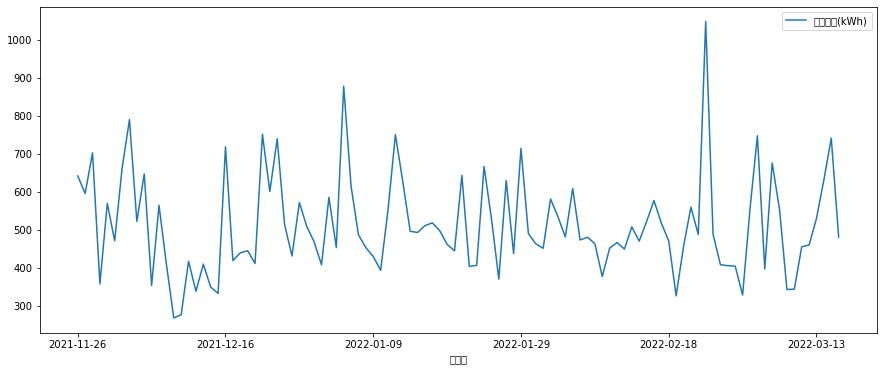

In [405]:
fig, ax = plt.subplots(1,1, figsize = (15,6))
compare[["년월일","열공급량(kWh)"]].set_index("년월일").plot(ax=ax)